In [1]:
import torch
import torchaudio

In [2]:
results = torch.load('result/res_DM_GTZAN_ConvNet_10ipc.pt', weights_only=False)

In [3]:
results['data'][0][0][20]

tensor([[[-0.1168,  0.1429, -0.2397,  ...,  0.8968,  0.9319,  0.6692],
         [ 1.2044, -0.2335, -0.7931,  ...,  1.7204,  1.0675,  1.1327],
         [ 0.8708,  0.7422,  0.3765,  ...,  2.8538,  2.4015,  2.3359],
         ...,
         [-2.4896, -2.3402, -1.1125,  ..., -0.0331, -0.2718, -0.4298],
         [-2.4720, -2.5792, -1.4755,  ...,  0.1881, -0.1392, -0.2228],
         [-2.4309, -2.5609, -1.6908,  ...,  0.3556, -0.0222, -0.0939]]])

In [4]:
spectrogram = results['data'][0][0][40]

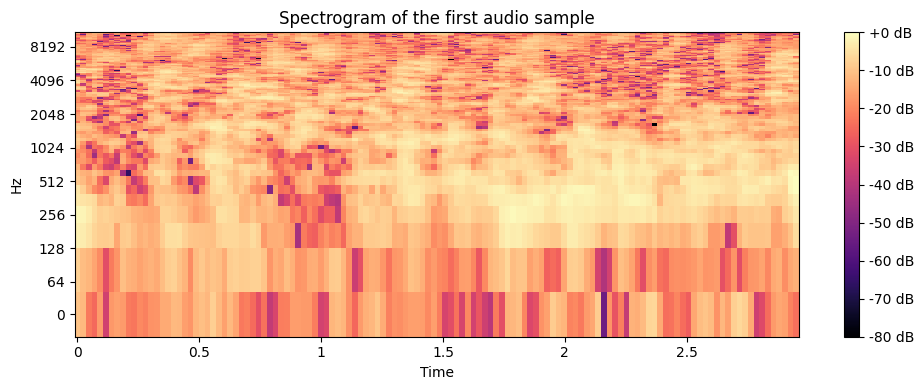

In [5]:
# display spectrogram
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import librosa
import matplotlib.pyplot as plt

def plot_spectrogram(spectrogram, title=None):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram.squeeze(0).numpy(), ref=np.max), y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()
plot_spectrogram(spectrogram, title='Spectrogram of the first audio sample')

In [6]:

for i in range(2048):
  try:
    transform = torchaudio.transforms.GriffinLim(n_fft = i)
    waveform = transform(spectrogram)
    print(i)
  except:
    continue

254
255


In [7]:
spectrogram = torch.abs(spectrogram)  # If it might be complex or have negative values
spectrogram = torch.clamp(spectrogram, min=1e-8) 

In [8]:
transform = torchaudio.transforms.GriffinLim(n_fft=255)
waveform = transform(spectrogram)

In [9]:
waveform

tensor([[ 0.0285, -0.0963,  0.1629,  ...,  0.0398, -0.1905, -0.2654]])

In [10]:
# play the waveform
import IPython.display as ipd
ipd.Audio(waveform.numpy(), rate=16000)


In [11]:
from utils import get_dataset, get_network, evaluate_synset

In [12]:
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('GTZAN', data_path = 'data')
net_eval = get_network( 'ConvNet', channel = channel, num_classes = num_classes, im_size = im_size).to('mps') 

In [13]:

from argparse import Namespace

args = Namespace(
    batch_size=32,
    num_workers=4,
    num_classes=num_classes,  # Replace with your variable
    im_size=im_size,          # Replace with your variable
    mean=mean,                # Replace with your variable
    std=std,                  # Replace with your variable
    device='mps',              # Add device later
    lr_net = 0.01,
    epoch_eval_train = 1000,
    batch_train = 256
)

In [14]:
image_syn_eval = results['data'][0][0]
label_syn_eval = results['data'][0][1]
print(image_syn_eval.shape)
print(label_syn_eval.shape)
network, acc_train, acc_test = evaluate_synset(0, net_eval, image_syn_eval, label_syn_eval, testloader, args)

torch.Size([100, 1, 128, 128])
torch.Size([100])
[2025-05-12 17:05:47] Evaluate_00: epoch = 1000 train time = 451 s train loss = 0.003782 train acc = 1.0000, test acc = 0.3443


In [25]:
# forward pass
net_eval.eval()
predicted_labels = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to('mps')
        labels = labels.to('mps')
        outputs = net_eval(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = [data[1] for data in testloader.dataset]

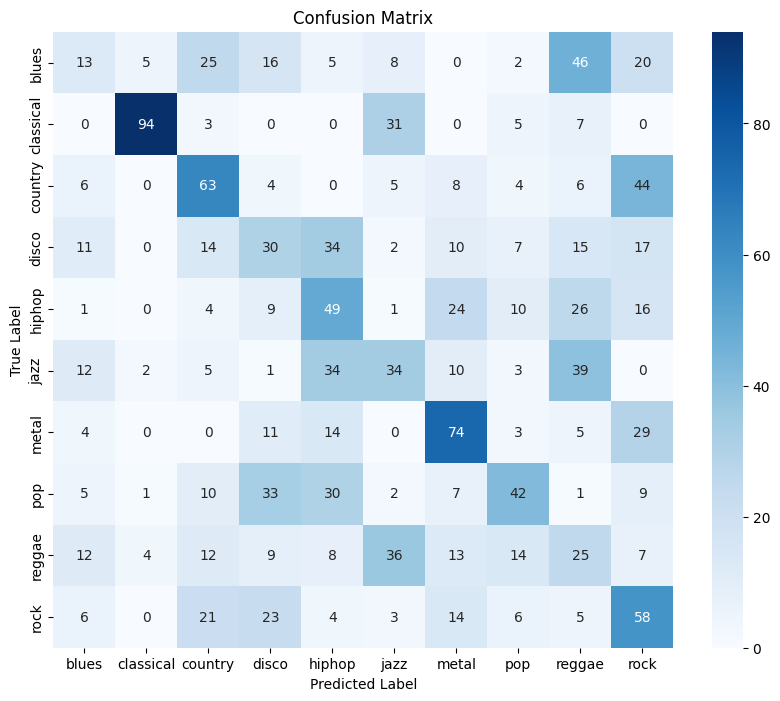

In [26]:
# display confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confusion_mtx = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()